In [3]:
import pandas as pd
import numpy as np
from simulator import conduct_simulation

# Experiments

# Input data processing
df = pd.read_table('iris.data', header=None)
raw_data = np.array(df)
pro_data = [[],[],[]]
for item in raw_data:
    pro_item = str(item[0]).split(',')
    pro_item = [eval(pro_item[0]),eval(pro_item[1]),eval(pro_item[2]),eval(pro_item[3]),pro_item[4]]
    if pro_item[4] == 'Iris-setosa':    
        pro_item[4] = 0
        pro_data[0].append(pro_item)
    if pro_item[4] == 'Iris-versicolor': 
        pro_item[4] = 1
        pro_data[1].append(pro_item)
    if pro_item[4] == 'Iris-virginica':  
        pro_item[4] = 2
        pro_data[2].append(pro_item)
pro_data = np.array(pro_data)

# Components for GMM model
components_num = 3

# Proportion of training and test sets
train_ratio_list = np.array([0.3,0.4,0.5,0.6,0.7,0.8,0.9])

# Monte Carlo experiments num
N = 100

# Simulation
mean_accuracy_classical, mean_accuracy_quantum_32, mean_accuracy_quantum_1024 = conduct_simulation(pro_data, train_ratio_list, components_num, N)


Train Ratio: 0.3
Iteration number: 0
Iteration number: 10
Iteration number: 20
Iteration number: 30
Iteration number: 40
Iteration number: 50
Iteration number: 60
Iteration number: 70
Iteration number: 80
Iteration number: 90
Train Ratio: 0.4
Iteration number: 0
Iteration number: 10
Iteration number: 20
Iteration number: 30
Iteration number: 40
Iteration number: 50
Iteration number: 60
Iteration number: 70
Iteration number: 80
Iteration number: 90
Train Ratio: 0.5
Iteration number: 0
Iteration number: 10
Iteration number: 20
Iteration number: 30
Iteration number: 40
Iteration number: 50
Iteration number: 60
Iteration number: 70
Iteration number: 80
Iteration number: 90
Train Ratio: 0.6
Iteration number: 0
Iteration number: 10
Iteration number: 20
Iteration number: 30
Iteration number: 40
Iteration number: 50
Iteration number: 60
Iteration number: 70
Iteration number: 80
Iteration number: 90
Train Ratio: 0.7
Iteration number: 0
Iteration number: 10
Iteration number: 20
Iteration number:

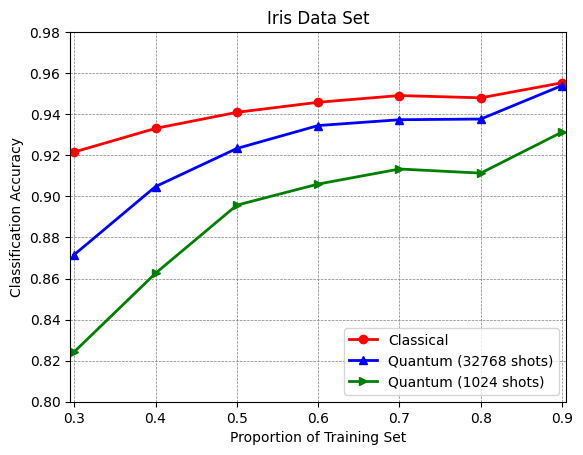

In [25]:
from plot_figure import plot_figure

# Plot
# plot_figure("Iris Data Set", 0.73, 0.98, train_ratio_list, mean_accuracy_classical, mean_accuracy_quantum_32, mean_accuracy_quantum_1024)


# Plot
# plot_figure("Wine Data Set", 0.5, 0.98, train_ratio_list, mean_accuracy_classical, mean_accuracy_quantum_32, mean_accuracy_quantum_1024, "wine.pdf")
import matplotlib.pyplot as plt
fig = plt.figure()

ax1 = fig.add_subplot(111)
lns1 = ax1.plot(train_ratio_list, mean_accuracy_classical, '-or', linewidth = 2.0, label = 'Classical')
lns2 = ax1.plot(train_ratio_list, mean_accuracy_quantum_32, '-^b', linewidth = 2.0, label = 'Quantum (32768 shots)')
lns3 = ax1.plot(train_ratio_list, mean_accuracy_quantum_1024, '->g', linewidth = 2.0, label = 'Quantum (1024 shots)')

plt.grid(color='gray', linestyle='--', linewidth=0.5)

lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='lower right')
ax1.set_xlim(0.295,0.905)
ax1.set_ylim(0.8, 0.98)
ax1.set_ylabel("Classification Accuracy")
ax1.set_xlabel("Proportion of Training Set")
plt.title("Iris Data Set")
plt.savefig("Iris.pdf", dpi=400)

In [ ]:
mean_accuracy_quantum_32